# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [2]:
tracks = pd.read_parquet("data/tracks.parquet")
catalog_names = pd.read_parquet("data/catalog_names.parquet")
interactions = pd.read_parquet("data/interactions.parquet")

In [3]:
tracks.head(3)

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]


In [4]:
catalog_names.head(3)

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow


In [5]:
interactions.head(3)

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21


In [6]:
tracks.memory_usage(deep=True).sum() / (1024 ** 2)

350.9522705078125

In [7]:
catalog_names.memory_usage(deep=True).sum() / (1024 ** 2)

263.70952892303467

In [8]:
interactions.memory_usage(deep=True).sum() / (1024 ** 2)

5520.226810455322

In [9]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [10]:
type_counts = catalog_names["type"].value_counts()

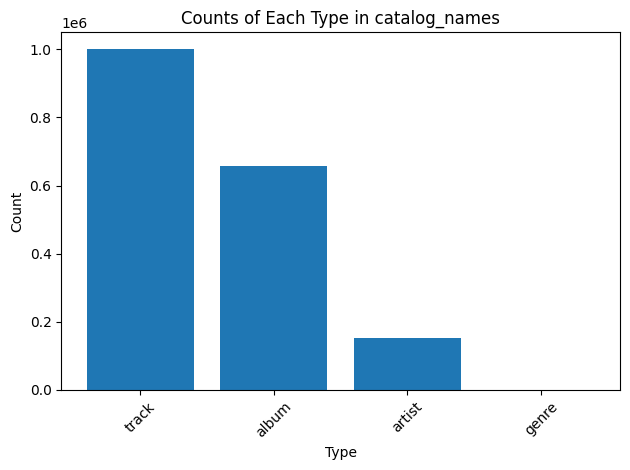

In [11]:
# Bar plot
plt.figure()
plt.bar(type_counts.index, type_counts.values)
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Counts of Each Type in catalog_names')
plt.xticks(rotation=45)  # Rotate labels if needed
plt.tight_layout()
plt.show()

In [12]:
del type_counts

In [13]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


In [14]:
catalog_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


In [15]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

Тип индентификаторов

Очевидно, что для track_id необходимо преобразование (так как нумерация не начиная с 0 через 1)

In [16]:
catalog_names[catalog_names["type"] == 'track']

,id,type,name
812471,26,track,Complimentary Me
812472,38,track,Momma's Boy
812473,135,track,Atticus
812474,136,track,24 Hours
812475,138,track,Don't Upset The Rhythm (Go Baby Go)
...,...,...,...
1812466,101478482,track,На лицо
1812467,101490148,track,Без капли мысли
1812468,101493057,track,SKITTLES
1812469,101495927,track,Москва


Проверим для user_id, на первый взгляд, с user_id все нормально

In [17]:
interactions["user_id"].unique()

array([      0,       1,       2, ..., 1374580, 1374581, 1374582],
      dtype=int32)

Но оказывается, что user_id не пронумерованы от 0 до n без пропусков и повторов. Поэтому user_id тоже требует преобразования при помощи LabelEncoder

In [18]:
import numpy as np

ids = interactions['user_id'].to_numpy()

# Убираем дубликаты
unique_ids = np.unique(ids)

# Проверка на полноту диапазона
if unique_ids[0] == 0 and np.array_equal(unique_ids, np.arange(len(unique_ids))):
    print("ID пронумерованы от 0 до n без пропусков и повторов.")
else:
    print("ID не соответствуют диапазону 0..n без пропусков.")

ID не соответствуют диапазону 0..n без пропусков.


In [19]:
del ids
del unique_ids

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

In [20]:
unq_songs_by_user = interactions.groupby("user_id")["track_id"].nunique()

Среднее кол-во прослушанных треков по пользователю

In [21]:
unq_songs_by_user.mean()

162.12241001266366

Медианное кол-во прослушанных треков по пользователю

In [22]:
unq_songs_by_user.median()

55.0

Стандартное отклонение кол-ва прослушанных треков по пользователю

In [23]:
unq_songs_by_user.std()

351.2846250431907

Максимальнвые и минимальные значения

In [24]:
unq_songs_by_user.max(), unq_songs_by_user.min()

(16637, 1)

Распределение кол-ва прослушанных треков по пользователям

<Axes: >

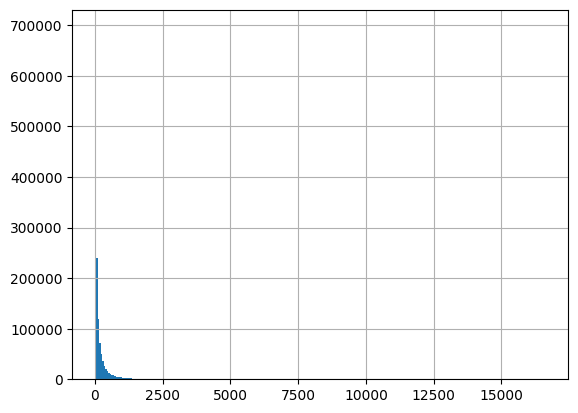

In [25]:
unq_songs_by_user.hist(bins=300)

In [26]:
del unq_songs_by_user

Наиболее популярные треки

In [27]:
popular_tracks = pd.merge(interactions["track_id"], catalog_names[catalog_names["type"] == 'track'][["id", "name"]], left_on="track_id", right_on="id", how="left")

/home/ak/Desktop/mle-project-sprint-4-v001/.venv_project/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ak/Desktop/mle-project-sprint-4-v001/.venv_project/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ak/Desktop/mle-project-sprint-4-v001/.venv_project/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


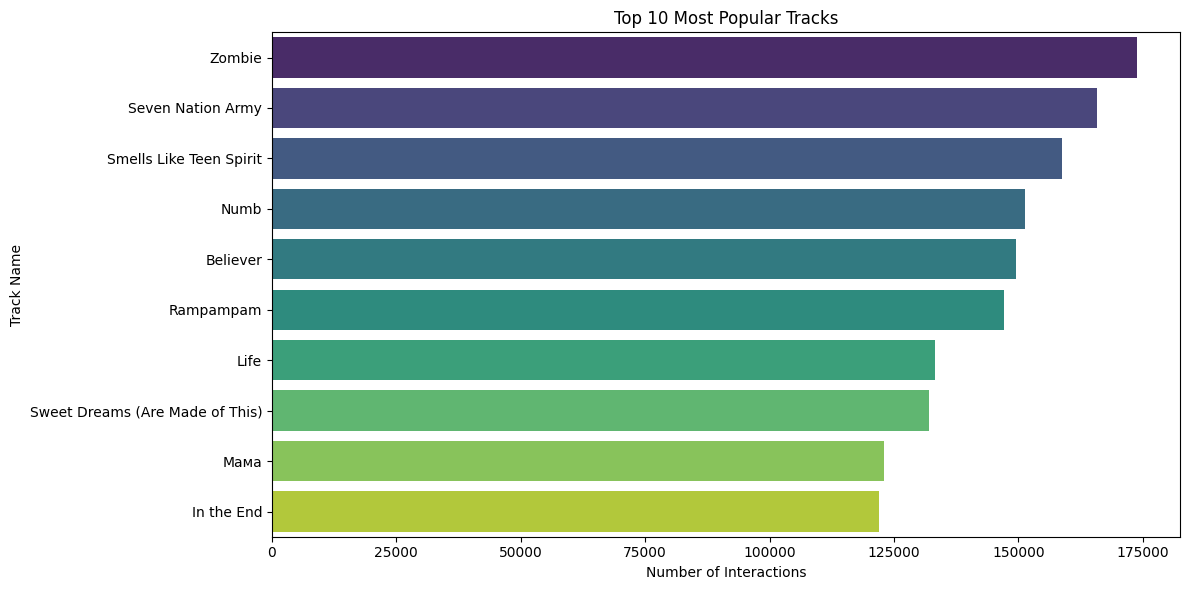

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of each track name
top_tracks = popular_tracks['name'].value_counts().nlargest(10)

# Create the barplot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_tracks.values, y=top_tracks.index, palette='viridis')
plt.xlabel('Number of Interactions')
plt.ylabel('Track Name')
plt.title('Top 10 Most Popular Tracks')
plt.tight_layout()
plt.show()

In [29]:
del popular_tracks

Наиболее популярные жанры

In [30]:
genre_counts = tracks["genres"].explode().value_counts().reset_index().sort_values(by="count", ascending=False)

In [31]:
catalog_names_genres = catalog_names[catalog_names["type"] == "genre"]
genre_counts = pd.merge(genre_counts, catalog_names_genres[["id", "name"]], left_on="genres", right_on="id", how="left")

В трэках есть некоторые жанры, которых нет в catalog_names

In [32]:
genre_counts[genre_counts["name"].isna()]["genres"].unique()

array([154, 161, 163, 158, 157, 151, 169, 155, 159, 164, 156, 162, 168,
       153, 160, 165, 146, 167, 131, 152, 126, 130, 132, 134, 135, 133,
       166, 148, 150, 124])

/home/ak/Desktop/mle-project-sprint-4-v001/.venv_project/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ak/Desktop/mle-project-sprint-4-v001/.venv_project/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ak/Desktop/mle-project-sprint-4-v001/.venv_project/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


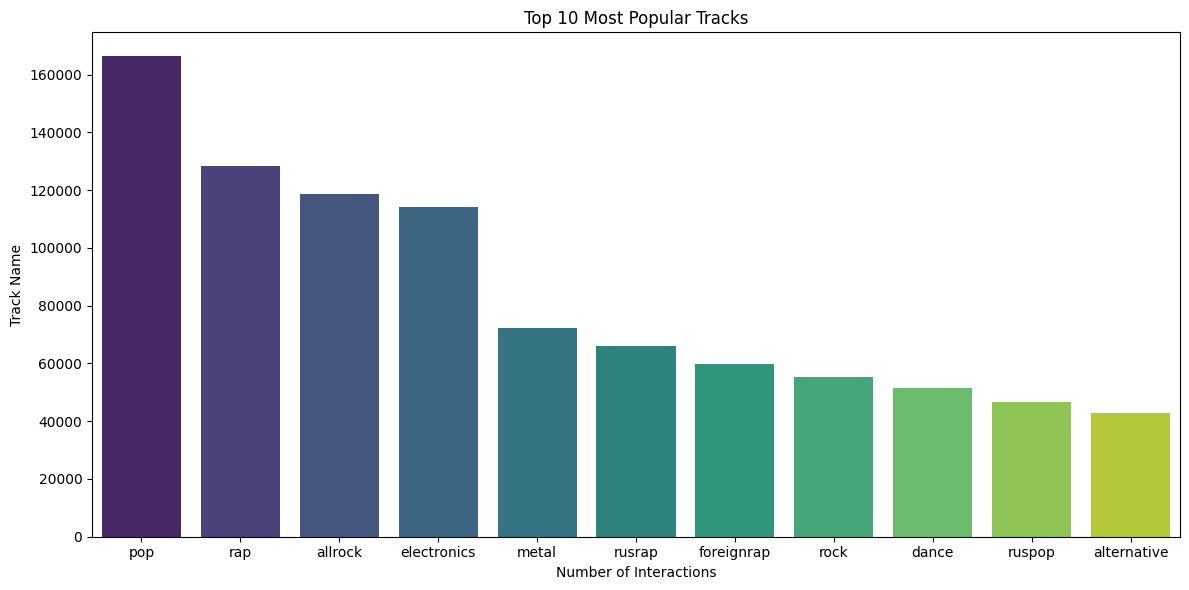

In [33]:
# Create the barplot
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.loc[:10, "name"].values, y=genre_counts.loc[:10, "count"].values, palette='viridis')
plt.xlabel('Number of Interactions')
plt.ylabel('Track Name')
plt.title('Top 10 Most Popular Tracks')
plt.tight_layout()
plt.show()

In [34]:
del genre_counts
del catalog_names_genres

Треки, которые никто не прослушал

In [35]:
tracks[~tracks["track_id"].isin(interactions["track_id"].values)]

,track_id,albums,artists,genres


Вывод: в interactions нет таких треков, которых бы не было в tracks

Все треки прослушивали

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [10]:
events = interactions.copy()
events = events.rename(columns={"track_id": "item_id"})
items = catalog_names.copy()

В items оставим только треки

In [11]:
items = items.rename(columns={"id": "item_id"})
items = items[items['type'] == 'track']

Пока удалим interactions и catalog_names для сохранения ресурсов

In [12]:
del interactions, catalog_names

# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [13]:
items.to_parquet("intermediate_data/items.parquet")
events.to_parquet("intermediate_data/events.parquet")

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

Перезагружае kernel и начинаем выполение с пункта 3

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
items = pd.read_parquet("intermediate_data/items.parquet")
events = pd.read_parquet("intermediate_data/events.parquet")

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [3]:
from datetime import datetime

cutoff_date = datetime(2022, 12, 16)

events_train = events[events["started_at"] < cutoff_date]
events_test = events[events["started_at"] >= cutoff_date]

In [4]:
events_train.shape, events_test.shape

((208731252, 4), (13898646, 4))

Пока удаляем events для экономии ресурсов

In [5]:
del events

# Топ популярных

Рассчитаем рекомендации как топ популярных.

Найдем топ популярных треков на основе последнего месяца из events_train

In [6]:
events_train["started_at"].min(), events_train["started_at"].max()

(Timestamp('2022-01-01 00:00:00'), Timestamp('2022-12-15 00:00:00'))

popularity_score - нормированное число уникальных слушателей трека

In [7]:
from sklearn.preprocessing import MinMaxScaler

top_start_date = pd.to_datetime("2022-11-15")
top_popular = events_train \
    .query("started_at >= @top_start_date") \
    .groupby("item_id").agg(users=("user_id", "nunique"))\
    .reset_index()\
    .rename(columns={"users": "popularity_score"})

scaler = MinMaxScaler()
top_popular["popularity_score"] = scaler.fit_transform(top_popular[["popularity_score"]])

Выбираем топ 100 рекомендаций с наивысшим рейтингом

In [8]:
top_popular = top_popular.sort_values(by="popularity_score", ascending=False)
top_popular = top_popular.iloc[:100, :]

In [9]:
top_popular

,item_id,popularity_score
777271,83063895,1.000000
619748,60292250,0.984435
772298,81848875,0.970732
667865,65851540,0.968993
753780,78426489,0.950985
...,...,...
593076,57104680,0.404868
437125,39946957,0.404165
801420,89305091,0.404040
579067,55291388,0.403130


In [10]:
import os
os.makedirs("recommendations", exist_ok=True)

In [11]:
top_popular.to_parquet('recommendations/top_popular.parquet')

Проверим рекомендации на тестовой выборке

In [12]:
item_popularity_recs = pd.merge(events_test, top_popular, left_on='item_id', right_on='item_id', how='left')

In [13]:
item_popularity_recs.head()

,user_id,item_id,track_seq,started_at,popularity_score
0,3,78194999,33,2022-12-20,0.552823
1,4,83375862,245,2022-12-18,NaN
2,4,83764704,246,2022-12-18,NaN
3,4,83858540,247,2022-12-20,NaN
4,4,84099295,248,2022-12-21,NaN


In [14]:
item_popularity_recs.shape, item_popularity_recs[item_popularity_recs['popularity_score'].notna()].shape

((13898646, 5), (660079, 5))

In [15]:
item_popularity_recs[item_popularity_recs['popularity_score'].notna()]["user_id"].unique().shape[0]\
/ item_popularity_recs["user_id"].unique().shape[0]

0.31625538432085765

Вывод - топ 100 популярных рекомендаций совпали по предпочтениям для 32 % пользователей из тестовой выборки

In [16]:
del top_popular
del item_popularity_recs

# Персональные

Рассчитаем персональные рекомендации.

In [17]:
events = pd.read_parquet("intermediate_data/events.parquet")

In [18]:
import scipy
import sklearn.preprocessing

# перекодируем идентификаторы пользователей:
# из имеющихся в последовательность 0, 1, 2, ...
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

# перекодируем идентификаторы объектов:
# из имеющихся в последовательность 0, 1, 2, ...
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["item_id"])
items["item_id_enc"] = item_encoder.transform(items["item_id"])
events_train["item_id_enc"] = item_encoder.transform(events_train["item_id"])
events_test["item_id_enc"] = item_encoder.transform(events_test["item_id"])

Обновим events_train, events_train, items в репозитории, сохраним энкодеры

In [19]:
events_train.to_parquet("intermediate_data/events_train.parquet")
events_test.to_parquet("intermediate_data/events_test.parquet")
items.to_parquet("intermediate_data/items.parquet")

In [20]:
import pickle

In [21]:
with open('models/user_encoder.pkl', 'wb') as f:
    pickle.dump(user_encoder, f)

In [22]:
with open('models/item_encoder.pkl', 'wb') as f:
    pickle.dump(item_encoder, f)

Удаляем events для сохранения памяти

In [23]:
del events

Формируем матрицу users-items

In [24]:
events_train_count = events_train.groupby(['user_id_enc', 'item_id_enc']).size().reset_index(name='play_count')

In [25]:
from scipy.sparse import csr_matrix

user_item_matrix_train = csr_matrix((
    events_train_count['play_count'],
    (events_train_count['user_id_enc'], events_train_count['item_id_enc'])
))

Сохраняем матрицу в intermediate_data

In [26]:
from scipy.sparse import save_npz, load_npz

save_npz("intermediate_data/user_item_matrix_train.npz", user_item_matrix_train)

Обучаем модель, берем 10 факторов и 50 итераций

In [27]:
from implicit.als import AlternatingLeastSquares

als_model = AlternatingLeastSquares(factors=10, iterations=50, regularization=0.05, random_state=0)
als_model.fit(user_item_matrix_train)

/home/ak/Desktop/mle-project-sprint-4-v001/.venv_project/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 16 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/50 [00:00<?, ?it/s]

Создаем репозиторий под модель и сохраняем модель 

In [28]:
import os
os.makedirs("models", exist_ok=True)

In [29]:
import pickle

with open("models/als_model.pkl", "wb") as f:
    pickle.dump(als_model, f)

Вычисляем рекомендации. Перед выполнением этого шага перезапускаем кернел и загружаем необходимые данные

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from scipy.sparse import load_npz

In [4]:
# Load
with open('models/user_encoder.pkl', 'rb') as f:
    user_encoder = pickle.load(f)

with open('models/als_model.pkl', 'rb') as f:
    als_model = pickle.load(f)

user_item_matrix_train = load_npz("intermediate_data/user_item_matrix_train.npz")

Получаем рекомендации на user_item_matrix_train

In [5]:
# получаем список всех возможных user_id (перекодированных)
user_ids_encoded = range(len(user_encoder.classes_))

# получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids_encoded,
    user_item_matrix_train[user_ids_encoded],
    filter_already_liked_items=False, N=10)

Загружаем item_encoder

In [6]:
with open('models/item_encoder.pkl', 'rb') as f:
    item_encoder = pickle.load(f)

In [7]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "item_id_enc": item_ids_enc.tolist(),
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["item_id_enc", "score"], ignore_index=True)

# приводим типы данных
als_recommendations["item_id_enc"] = als_recommendations["item_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["item_id"] = item_encoder.inverse_transform(als_recommendations["item_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "item_id_enc"])

In [8]:
als_recommendations.to_parquet("recommendations/personal_als.parquet")

In [9]:
als_recommendations

,score,user_id,item_id
0,0.005717,0,35505245
1,0.005681,0,732401
2,0.005520,0,178529
3,0.005508,0,580880
4,0.005497,0,560468
...,...,...,...
13732205,0.147550,1374582,51241318
13732206,0.143306,1374582,57921154
13732207,0.140446,1374582,56920237
13732208,0.138482,1374582,62352387


# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from scipy.sparse import load_npz

In [2]:
events_train = pd.read_parquet("intermediate_data/events_train.parquet")

In [3]:
with open('models/als_model.pkl', 'rb') as f:
    als_model = pickle.load(f)

In [4]:
with open('models/item_encoder.pkl', 'rb') as f:
    item_encoder = pickle.load(f)

In [5]:
# получим энкодированные идентификаторы всех объектов, известных нам из events_train
train_item_ids_enc = events_train['item_id_enc'].unique()

max_similar_items = 10

# получаем списки похожих объектов, используя ранее полученную ALS-модель
# метод similar_items возвращает и сам объект, как наиболее похожий
# этот объект мы позже отфильтруем, но сейчас запросим на 1 больше
similar_items = als_model.similar_items(train_item_ids_enc, N=max_similar_items+1)

# преобразуем полученные списки в табличный формат
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

similar_items = pd.DataFrame({
    "item_id_enc": train_item_ids_enc,
    "sim_item_id_enc": sim_item_item_ids_enc.tolist(), 
    "score": sim_item_scores.tolist()})
similar_items = similar_items.explode(["sim_item_id_enc", "score"])

# приводим типы данных
similar_items["sim_item_id_enc"] = similar_items["sim_item_id_enc"].astype("int")
similar_items["score"] = similar_items["score"].astype("float")

In [6]:
# получаем изначальные идентификаторы
similar_items["item_id_1"] = item_encoder.inverse_transform(similar_items["item_id_enc"])
similar_items["item_id_2"] = item_encoder.inverse_transform(similar_items["sim_item_id_enc"])
similar_items = similar_items.drop(columns=["item_id_enc", "sim_item_id_enc"])

# убираем пары с одинаковыми объектами
similar_items = similar_items.query("item_id_1 != item_id_2")

In [8]:
similar_items

,score,item_id_1,item_id_2
0,0.983613,99262,17747977
0,0.978718,99262,695860
0,0.978281,99262,20266461
0,0.976782,99262,2337217
0,0.976522,99262,31895895
...,...,...,...
999694,0.964755,94642241,99552500
999694,0.961888,94642241,66022588
999694,0.961709,94642241,88722825
999694,0.959551,94642241,99262309


Сохраним рекомендации

In [7]:
similar_items.to_parquet("recommendations/similar.parquet")

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.